In [1]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage import io
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
!unzip -q 'Group_5.zip'

In [3]:
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

train_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/Group_5/train",seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2150 files belonging to 5 classes.


In [5]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/Group_5/test",seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 250 files belonging to 5 classes.


In [6]:
if train_dataset.class_names==test_dataset.class_names:
    class_names= train_dataset.class_names
else:
    class_names = "Classes don't match among train, test, and validation dataset"
class_names

['fence', 'pill-bottle', 'projectile', 'reel', 'snail']

In [7]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 3 2 0 0 0 2 4 4 3 2 1 3 2 2 2 0 1 1 1 2 4 1 2 1 4 0 2 3 2 0 3]


In [8]:
# plt.figure(figsize=(15, 15))
# for image_batch, labels_batch in train_dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
#         plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split  + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    # val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    val_ds = ds.skip(train_size)

    return train_ds, val_ds

train_ds, val_ds = get_dataset_partitions_tf(train_dataset)
len(train_ds),len(val_ds),len(test_dataset)

(54, 14, 8)

In [10]:
class_counts = {}

# Iterate through the dataset and count occurrences of each class
for features, labels in train_ds:
    for label in labels.numpy():  # Assuming labels are TensorFlow tensors
        label = int(label)  # Convert label to an integer
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Print the class counts
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples")

Class 4: 314 samples
Class 0: 387 samples
Class 1: 421 samples
Class 3: 195 samples
Class 2: 411 samples


###Cache, Shuffle, Prefetch

In [11]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

###Data Augmentation

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

######Saving Models

In [15]:
save_dir = '/content/Model_Alex'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

##AlexNet from scratch

In [16]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model,load_model
import itertools

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def alexnet(input_shape, num_classes):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), input_shape=input_shape, padding='valid', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten
    model.add(layers.Flatten())

    # Layer 6
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))

    # Layer 7
    model.add(layers.Dense(512, activation='relu'))

    # Layer 8
    model.add(layers.Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Defining the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Creating the AlexNet model
alexnet_model = alexnet(input_shape, num_classes)

# Displaying the model summary
alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)      

In [18]:
alexnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = alexnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - 28s 326ms/step - loss: 11.5661 - accuracy: 0.2462 - val_loss: 1.5828 - val_accuracy: 0.2478
Epoch 2/50
54/54 [==============================] - 12s 222ms/step - loss: 1.5840 - accuracy: 0.2385 - val_loss: 1.5840 - val_accuracy: 0.2321
Epoch 3/50
54/54 [==============================] - 12s 228ms/step - loss: 1.5844 - accuracy: 0.2321 - val_loss: 1.5855 - val_accuracy: 0.2321
Epoch 4/50
54/54 [==============================] - 12s 219ms/step - loss: 1.5830 - accuracy: 0.2350 - val_loss: 1.5823 - val_accuracy: 0.2478
Epoch 5/50
54/54 [==============================] - 11s 208ms/step - loss: 1.5833 - accuracy: 0.2309 - val_loss: 1.5834 - val_accuracy: 0.2478
Epoch 6/50
54/54 [==============================] - 12s 212ms/step - loss: 1.5843 - accuracy: 0.2350 - val_loss: 1.5819 - val_accuracy: 0.2478
Epoch 7/50
54/54 [==============================] - 12s 222ms/step - loss: 1.5836 - accuracy: 0.2321 - val_loss: 1.5830 - val_accuracy: 0.247

In [20]:
model_alex = tf.keras.models.load_model("/content/Model_Alex/checkpoint-01-1.58.h5")

In [21]:
scores = alexnet_model.evaluate(test_ds)
test_loss, test_accuracy = alexnet_model.evaluate(test_ds)

8/8 [==============================] - 0s 15ms/step - loss: 1.6423 - accuracy: 0.2000


8/8 [==============================] - 0s 23ms/step


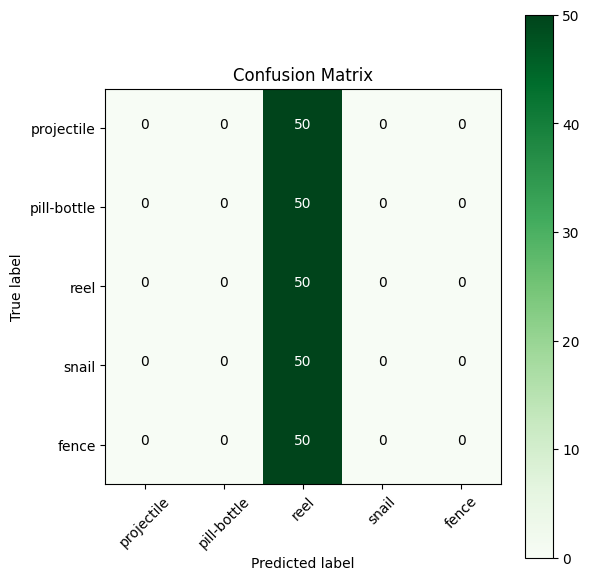

In [23]:
predictions_alex = model_alex.predict(test_ds)
predicted_label_alex = np.argmax(predictions_alex, axis=1)
true_label_alex = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx_alex = confusion_matrix(true_label_alex, predicted_label_alex)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['projectile', 'pill-bottle', 'reel', 'snail', 'fence']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx_alex, class_names)
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_label_alex, predicted_label_alex, target_names=['projectile', 'pill-bottle', 'reel', 'snail', 'fence'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

  projectile       0.00      0.00      0.00        50
 pill-bottle       0.00      0.00      0.00        50
        reel       0.20      1.00      0.33        50
       snail       0.00      0.00      0.00        50
       fence       0.00      0.00      0.00        50

    accuracy                           0.20       250
   macro avg       0.04      0.20      0.07       250
weighted avg       0.04      0.20      0.07       250



In [25]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx_alex.shape[0]):
    tp = confusion_mtx_alex[class_label, class_label]
    fn = np.sum(confusion_mtx_alex[class_label, :]) - tp
    fp = np.sum(confusion_mtx_alex[:, class_label]) - tp
    tn = np.sum(confusion_mtx_alex) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx_alex.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.2
Specificity (Average): 0.8
PPV (Positive Predictive Value) (Average): nan
NPV (Negative Predictive Value) (Average): nan


In [26]:
show = {}
show['AlexNet'] = scores[1]

In [27]:
history.history.keys()
history.history

{'loss': [11.56611156463623,
  1.5840051174163818,
  1.5844237804412842,
  1.5829962491989136,
  1.5832916498184204,
  1.5842739343643188,
  1.5835529565811157,
  1.583181381225586,
  1.582700252532959,
  1.5827770233154297,
  1.5829273462295532,
  1.584331750869751,
  1.583555817604065,
  1.58290433883667,
  1.5836204290390015,
  1.5828466415405273,
  1.5826478004455566,
  1.5840028524398804,
  1.582791805267334,
  1.5826841592788696,
  1.6938567161560059,
  1.5851247310638428,
  1.5831992626190186,
  1.5825337171554565,
  1.5824421644210815,
  1.5820872783660889,
  1.5825066566467285,
  1.5830037593841553,
  1.583050012588501,
  1.5826575756072998,
  1.582271933555603,
  1.5826767683029175,
  1.5897458791732788,
  1.5824204683303833,
  1.5825531482696533,
  1.5824238061904907,
  1.5824005603790283,
  1.5822620391845703,
  1.5824270248413086,
  1.582592487335205,
  1.5823307037353516,
  1.5826563835144043,
  1.5823423862457275,
  1.582069993019104,
  1.5823475122451782,
  1.5829590559

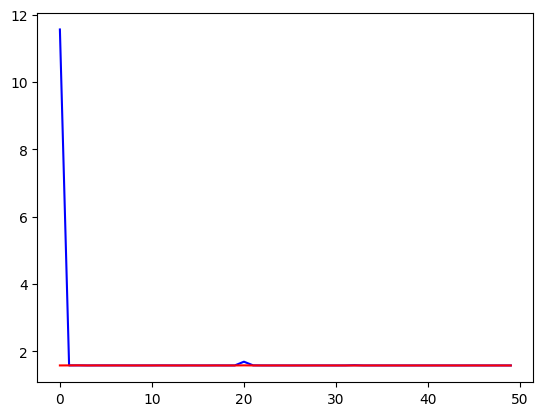

In [28]:
plt.plot(range(50), history.history["loss"][:50], 'b')
plt.plot(range(50), history.history["val_loss"][:50], 'r')
plt.show()

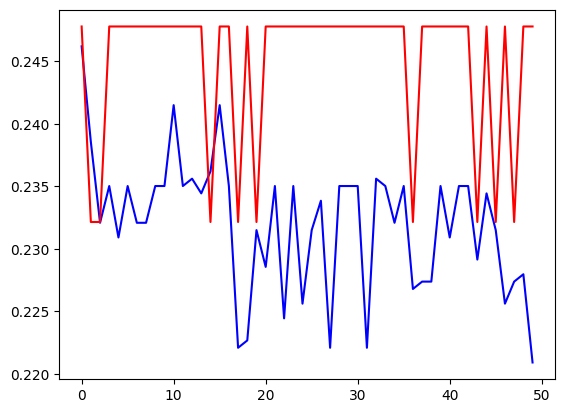

In [29]:
plt.plot(range(50), history.history["accuracy"][:50], 'b')
plt.plot(range(50), history.history["val_accuracy"][:50], 'r')
plt.show()

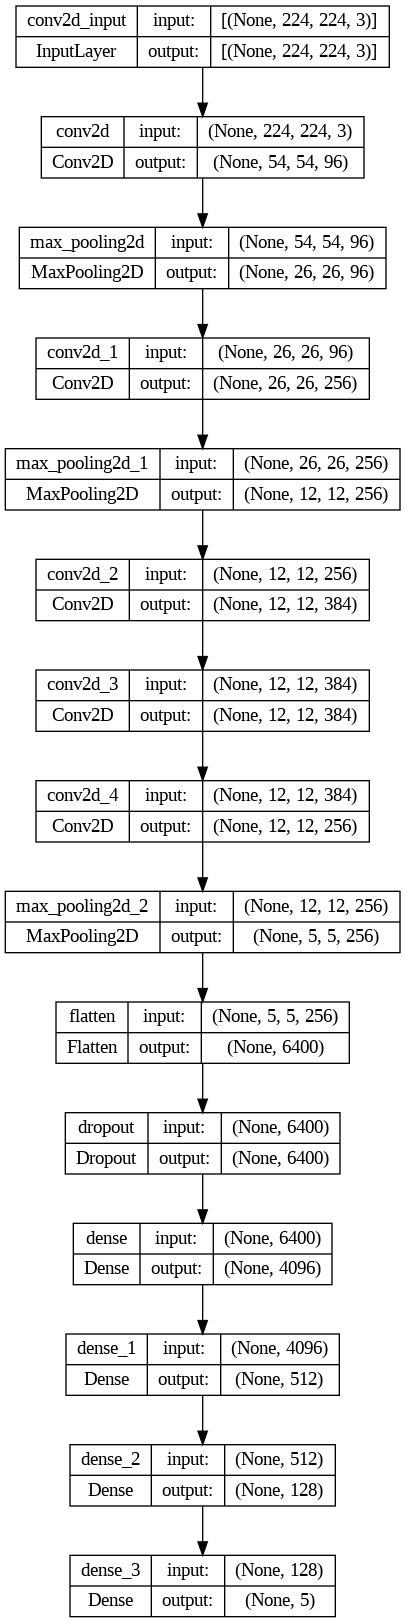

In [30]:
tf.keras.utils.plot_model(alexnet_model, show_shapes=True)

##ResNet from Scratch

In [31]:
save_dir = '/content/Model_ResNet'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the Residual Block
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the ResNet model
def build_resnet(input_shape, num_classes, num_blocks, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(5, 5), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Building the residual blocks
    for i in range(3):
        stride = 1 if i == 0 else 2  # First block uses stride 1, the rest use stride 2
        x = residual_block(x, filters=num_filters, stride=stride)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)

    return model

input_shape = (224, 224, 3)
num_classes = 5

num_blocks = 3
num_filters = 64

resnet_model = build_resnet(input_shape, num_classes, num_blocks, num_filters)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 112, 112, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [33]:
resnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history_res = resnet_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
54/54 [==============================] - 27s 347ms/step - loss: 1.3829 - accuracy: 0.4424 - val_loss: 19.3790 - val_accuracy: 0.2254
Epoch 2/100
54/54 [==============================] - 12s 230ms/step - loss: 1.2553 - accuracy: 0.5159 - val_loss: 6.6109 - val_accuracy: 0.3192
Epoch 3/100
54/54 [==============================] - 13s 234ms/step - loss: 1.2136 - accuracy: 0.5223 - val_loss: 4.9199 - val_accuracy: 0.3259
Epoch 4/100
54/54 [==============================] - 12s 223ms/step - loss: 1.1891 - accuracy: 0.5311 - val_loss: 2.1087 - val_accuracy: 0.4241
Epoch 5/100
54/54 [==============================] - 12s 222ms/step - loss: 1.1633 - accuracy: 0.5458 - val_loss: 1.3785 - val_accuracy: 0.5112
Epoch 6/100
54/54 [==============================] - 14s 250ms/step - loss: 1.1480 - accuracy: 0.5582 - val_loss: 5.1461 - val_accuracy: 0.2812
Epoch 7/100
54/54 [==============================] - 13s 237ms/step - loss: 1.1341 - accuracy: 0.5611 - val_loss: 2.1662 - val_accuracy

In [35]:
model_resnet = tf.keras.models.load_model("/content/Model_ResNet/checkpoint-89-0.78.h5")

In [36]:
scores_res = resnet_model.evaluate(test_ds)
test_loss, test_accuracy = resnet_model.evaluate(test_ds)

8/8 [==============================] - 0s 19ms/step - loss: 2.4128 - accuracy: 0.4760


8/8 [==============================] - 0s 20ms/step


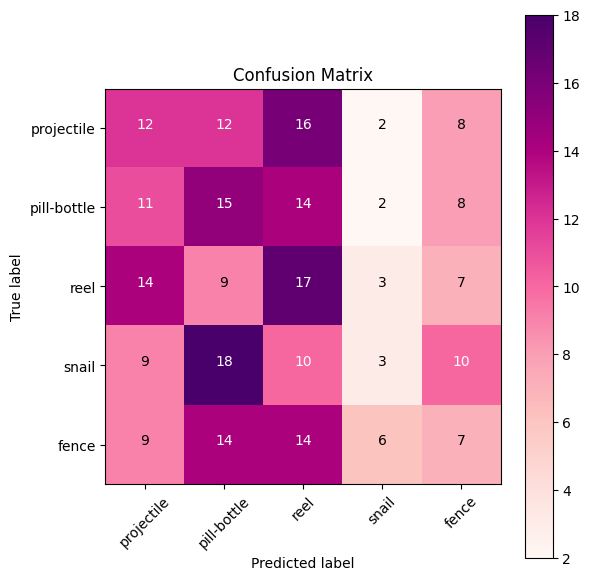

In [37]:
predictions_res = model_resnet.predict(test_ds)
predicted_label_res = np.argmax(predictions_res, axis=1)
true_label_res = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx_res = confusion_matrix(true_label_res, predicted_label_res)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['projectile', 'pill-bottle', 'reel', 'snail', 'fence']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx_res, class_names)
plt.show()

In [38]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_label_res, predicted_label_res, target_names=['projectile', 'pill-bottle', 'reel', 'snail', 'fence'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

  projectile       0.22      0.24      0.23        50
 pill-bottle       0.22      0.30      0.25        50
        reel       0.24      0.34      0.28        50
       snail       0.19      0.06      0.09        50
       fence       0.17      0.14      0.16        50

    accuracy                           0.22       250
   macro avg       0.21      0.22      0.20       250
weighted avg       0.21      0.22      0.20       250



In [39]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx_res.shape[0]):
    tp = confusion_mtx_res[class_label, class_label]
    fn = np.sum(confusion_mtx_res[class_label, :]) - tp
    fp = np.sum(confusion_mtx_res[:, class_label]) - tp
    tn = np.sum(confusion_mtx_res) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx_res.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.21600000000000003
Specificity (Average): 0.8039999999999999
PPV (Positive Predictive Value) (Average): 0.20814133463884912
NPV (Negative Predictive Value) (Average): 0.8045692730608932


In [40]:
show['ResNet50'] = scores_res[1]

history_res.history.keys()
history_res.history

{'loss': [1.3829210996627808,
  1.2552516460418701,
  1.2135597467422485,
  1.189117193222046,
  1.1632530689239502,
  1.147952914237976,
  1.1341049671173096,
  1.1154166460037231,
  1.1025465726852417,
  1.101858139038086,
  1.0824024677276611,
  1.0740268230438232,
  1.0580641031265259,
  1.0513813495635986,
  1.0347472429275513,
  1.0339303016662598,
  1.0326497554779053,
  1.0101473331451416,
  0.9951145052909851,
  0.9828137755393982,
  0.9598172903060913,
  0.9828274846076965,
  0.9653303623199463,
  0.9379541277885437,
  0.9277709722518921,
  0.9372523427009583,
  0.9171908497810364,
  0.892933189868927,
  0.9030715823173523,
  0.8865209221839905,
  0.8787175416946411,
  0.8816094398498535,
  0.8750632405281067,
  0.8540048599243164,
  0.8515394330024719,
  0.8200329542160034,
  0.8446782827377319,
  0.8163094520568848,
  0.809792160987854,
  0.8081594109535217,
  0.8318076133728027,
  0.8240540623664856,
  0.7672387361526489,
  0.787466824054718,
  0.7735040783882141,
  0.7612

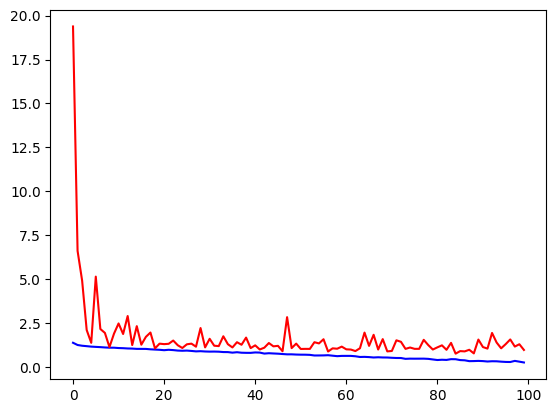

In [41]:
plt.plot(range(100), history_res.history["loss"][:100], 'b')
plt.plot(range(100), history_res.history["val_loss"][:100], 'r')
plt.show()

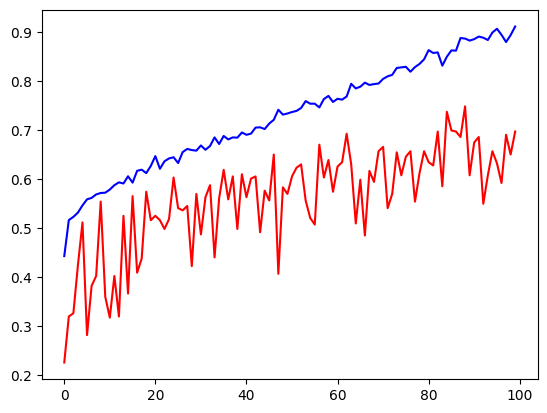

In [42]:
plt.plot(range(100), history_res.history["accuracy"][:100], 'b')
plt.plot(range(100), history_res.history["val_accuracy"][:100], 'r')
plt.show()

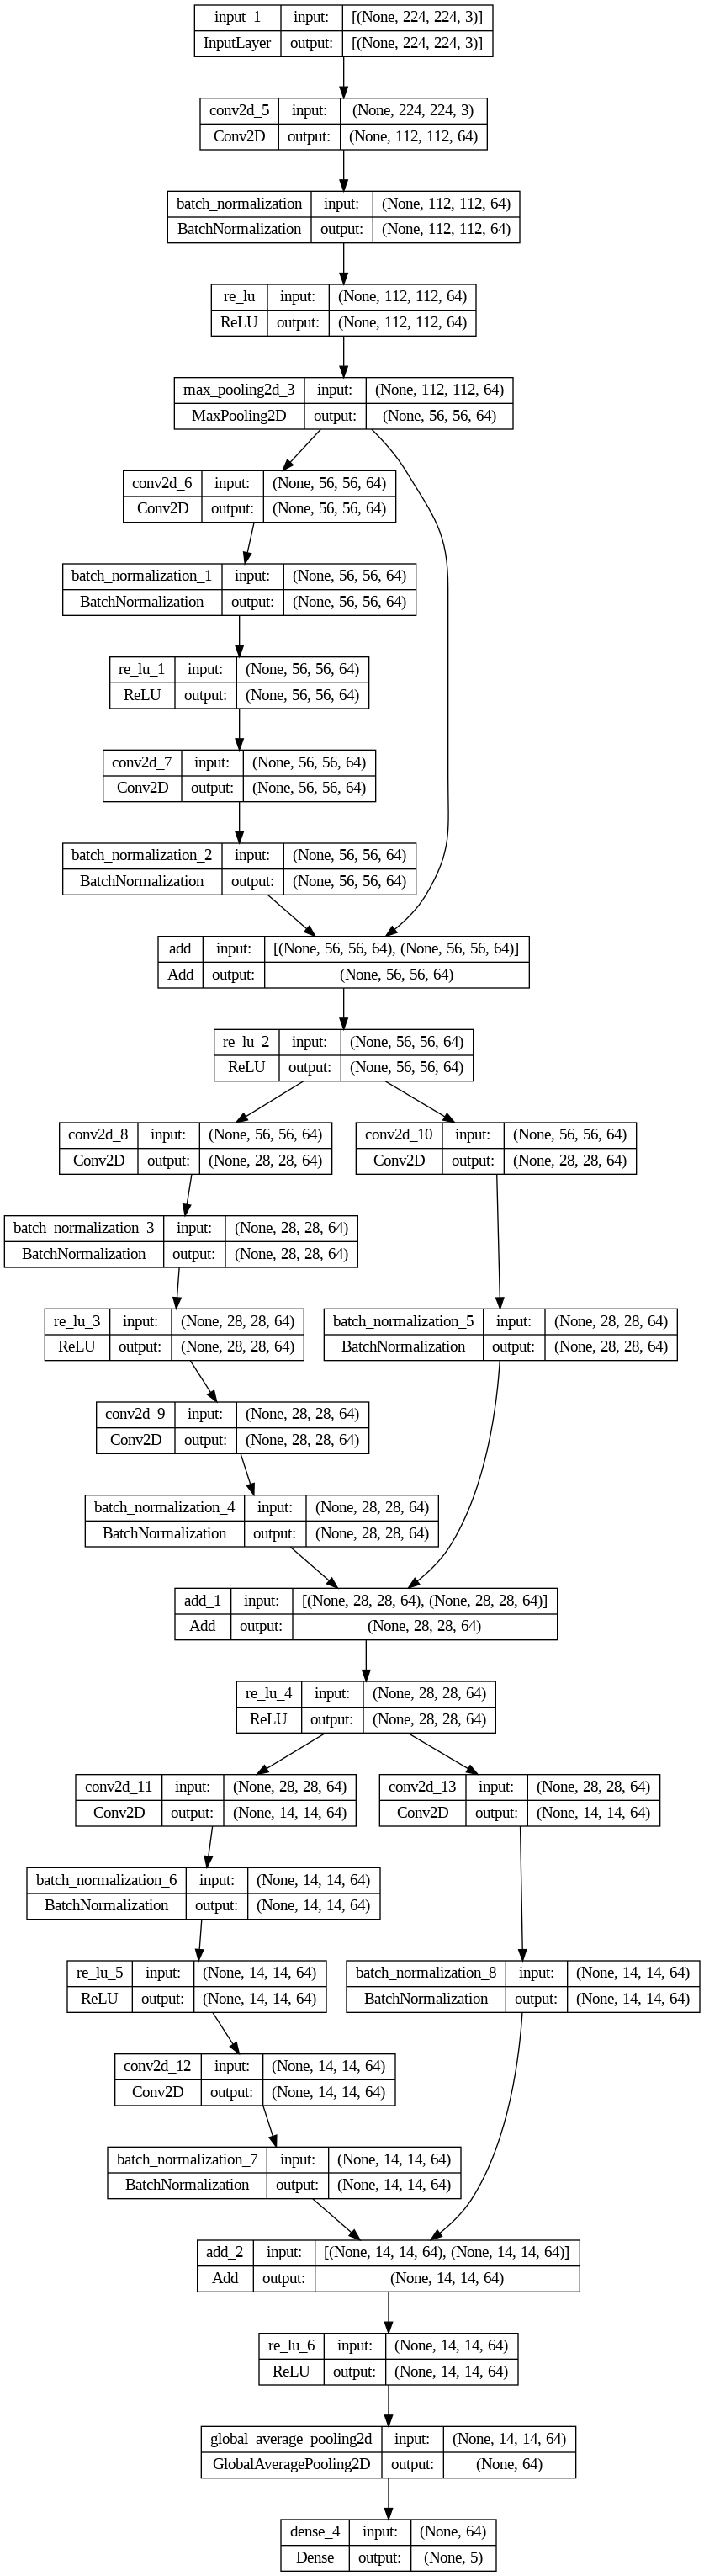

In [43]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

###InceptionNet from Scratch

In [44]:
save_dir = '/content/Model_Inception'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model

# Define a custom Inception-like block
def inception_block(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 Convolution followed by 5x5 Convolution
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 Max Pooling followed by 1x1 Convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return output

# Define the custom InceptionNet model
def build_inception_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Build the custom inception-like blocks
    x = inception_block(x, [64, 128, 128, 32, 32, 32])
    x = inception_block(x, [128, 192, 192, 96, 96, 64])

    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Flatten and add a Dense layer for classification
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build the custom InceptionNet model
inception_model = build_inception_net(input_shape, num_classes)

# Display model summary
inception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)           0         ['conv2d_14[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_16 (Conv2D)          (None, 56, 56, 128)          8320      ['max_pooling2d_4[0][0]'

In [46]:
inception_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history_inception =inception_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=65,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/65
54/54 [==============================] - 61s 912ms/step - loss: 287.0131 - accuracy: 0.2803 - val_loss: 1.5121 - val_accuracy: 0.3616
Epoch 2/65
54/54 [==============================] - 38s 714ms/step - loss: 1.5152 - accuracy: 0.3531 - val_loss: 1.4690 - val_accuracy: 0.4062
Epoch 3/65
54/54 [==============================] - 36s 680ms/step - loss: 1.4772 - accuracy: 0.3707 - val_loss: 1.4258 - val_accuracy: 0.4174
Epoch 4/65
54/54 [==============================] - 30s 563ms/step - loss: 1.4525 - accuracy: 0.3931 - val_loss: 1.4032 - val_accuracy: 0.4353
Epoch 5/65
54/54 [==============================] - 40s 744ms/step - loss: 1.4408 - accuracy: 0.4025 - val_loss: 1.3777 - val_accuracy: 0.4598
Epoch 6/65
54/54 [==============================] - 18s 328ms/step - loss: 1.4163 - accuracy: 0.4177 - val_loss: 1.3740 - val_accuracy: 0.4554
Epoch 7/65
54/54 [==============================] - 16s 294ms/step - loss: 1.4245 - accuracy: 0.3913 - val_loss: 1.4034 - val_accuracy: 0.42

In [48]:
model_inception = tf.keras.models.load_model("/content/Model_Inception/checkpoint-63-1.01.h5")

In [49]:
scores_inception = inception_model.evaluate(test_ds)

8/8 [==============================] - 3s 405ms/step - loss: 1.4600 - accuracy: 0.4560


8/8 [==============================] - 1s 58ms/step


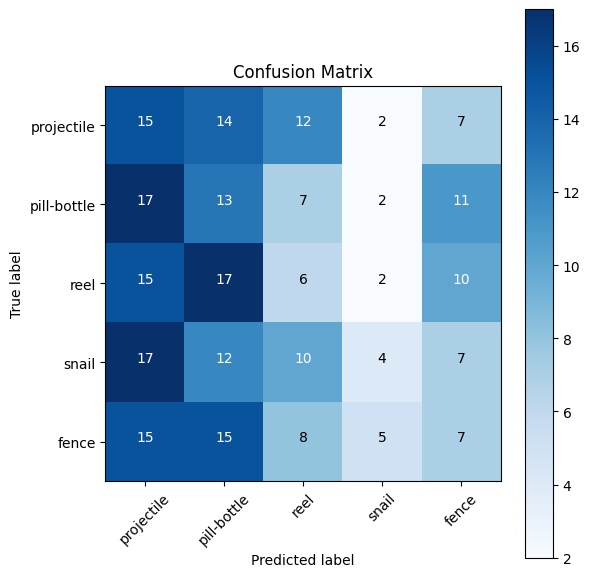

In [50]:
predictions_inception = model_inception.predict(test_ds)
predicted_label_inception = np.argmax(predictions_inception, axis=1)
true_label_inception = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx_inception = confusion_matrix(true_label_inception, predicted_label_inception)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['projectile', 'pill-bottle', 'reel', 'snail', 'fence']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx_inception, class_names)
plt.show()

In [51]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_label_res, predicted_label_res, target_names=['projectile', 'pill-bottle', 'reel', 'snail', 'fence'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

  projectile       0.22      0.24      0.23        50
 pill-bottle       0.22      0.30      0.25        50
        reel       0.24      0.34      0.28        50
       snail       0.19      0.06      0.09        50
       fence       0.17      0.14      0.16        50

    accuracy                           0.22       250
   macro avg       0.21      0.22      0.20       250
weighted avg       0.21      0.22      0.20       250



In [52]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx_inception.shape[0]):
    tp = confusion_mtx_inception[class_label, class_label]
    fn = np.sum(confusion_mtx_inception[class_label, :]) - tp
    fp = np.sum(confusion_mtx_inception[:, class_label]) - tp
    tn = np.sum(confusion_mtx_inception) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx_inception.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.18
Specificity (Average): 0.7949999999999999
PPV (Positive Predictive Value) (Average): 0.18916804526501568
NPV (Negative Predictive Value) (Average): 0.7947163780514225


In [53]:
show['InceptionNet'] = scores_inception[1]

In [54]:
history_inception.history.keys()
history_inception.history

{'loss': [287.01312255859375,
  1.5151838064193726,
  1.4772355556488037,
  1.4525479078292847,
  1.4408050775527954,
  1.416271686553955,
  1.424543857574463,
  1.4157156944274902,
  1.3939048051834106,
  1.4168164730072021,
  1.4042816162109375,
  1.392553448677063,
  1.380495548248291,
  1.3616172075271606,
  1.3658983707427979,
  1.3506625890731812,
  1.3223963975906372,
  1.3123480081558228,
  1.3261669874191284,
  1.309035301208496,
  1.2837213277816772,
  1.299364447593689,
  1.2944886684417725,
  1.2800055742263794,
  1.2716827392578125,
  1.282218098640442,
  1.265663743019104,
  1.2422388792037964,
  1.2710435390472412,
  1.243492841720581,
  1.253584384918213,
  1.2277660369873047,
  1.2155377864837646,
  1.214454174041748,
  1.2235229015350342,
  1.2278602123260498,
  1.205463171005249,
  1.1968897581100464,
  1.1853407621383667,
  1.1752268075942993,
  1.2081257104873657,
  1.1503705978393555,
  1.1693094968795776,
  1.153835654258728,
  1.161300539970398,
  1.154215216636

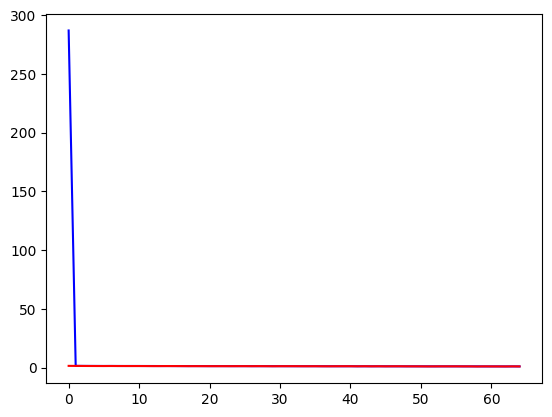

In [55]:
plt.plot(range(65), history_inception.history["loss"][:65], 'b')
plt.plot(range(65), history_inception.history["val_loss"][:65], 'r')
plt.show()

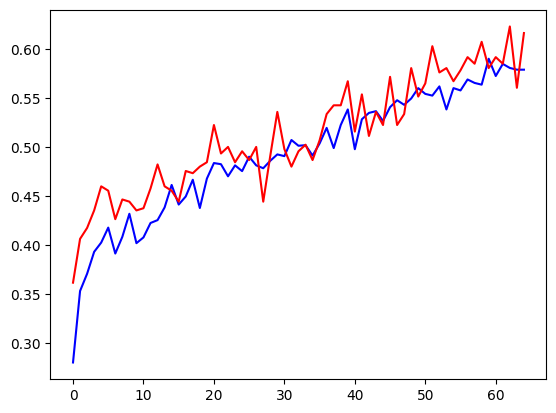

In [56]:
plt.plot(range(65), history_inception.history["accuracy"][:65], 'b')
plt.plot(range(65), history_inception.history["val_accuracy"][:65], 'r')
plt.show()

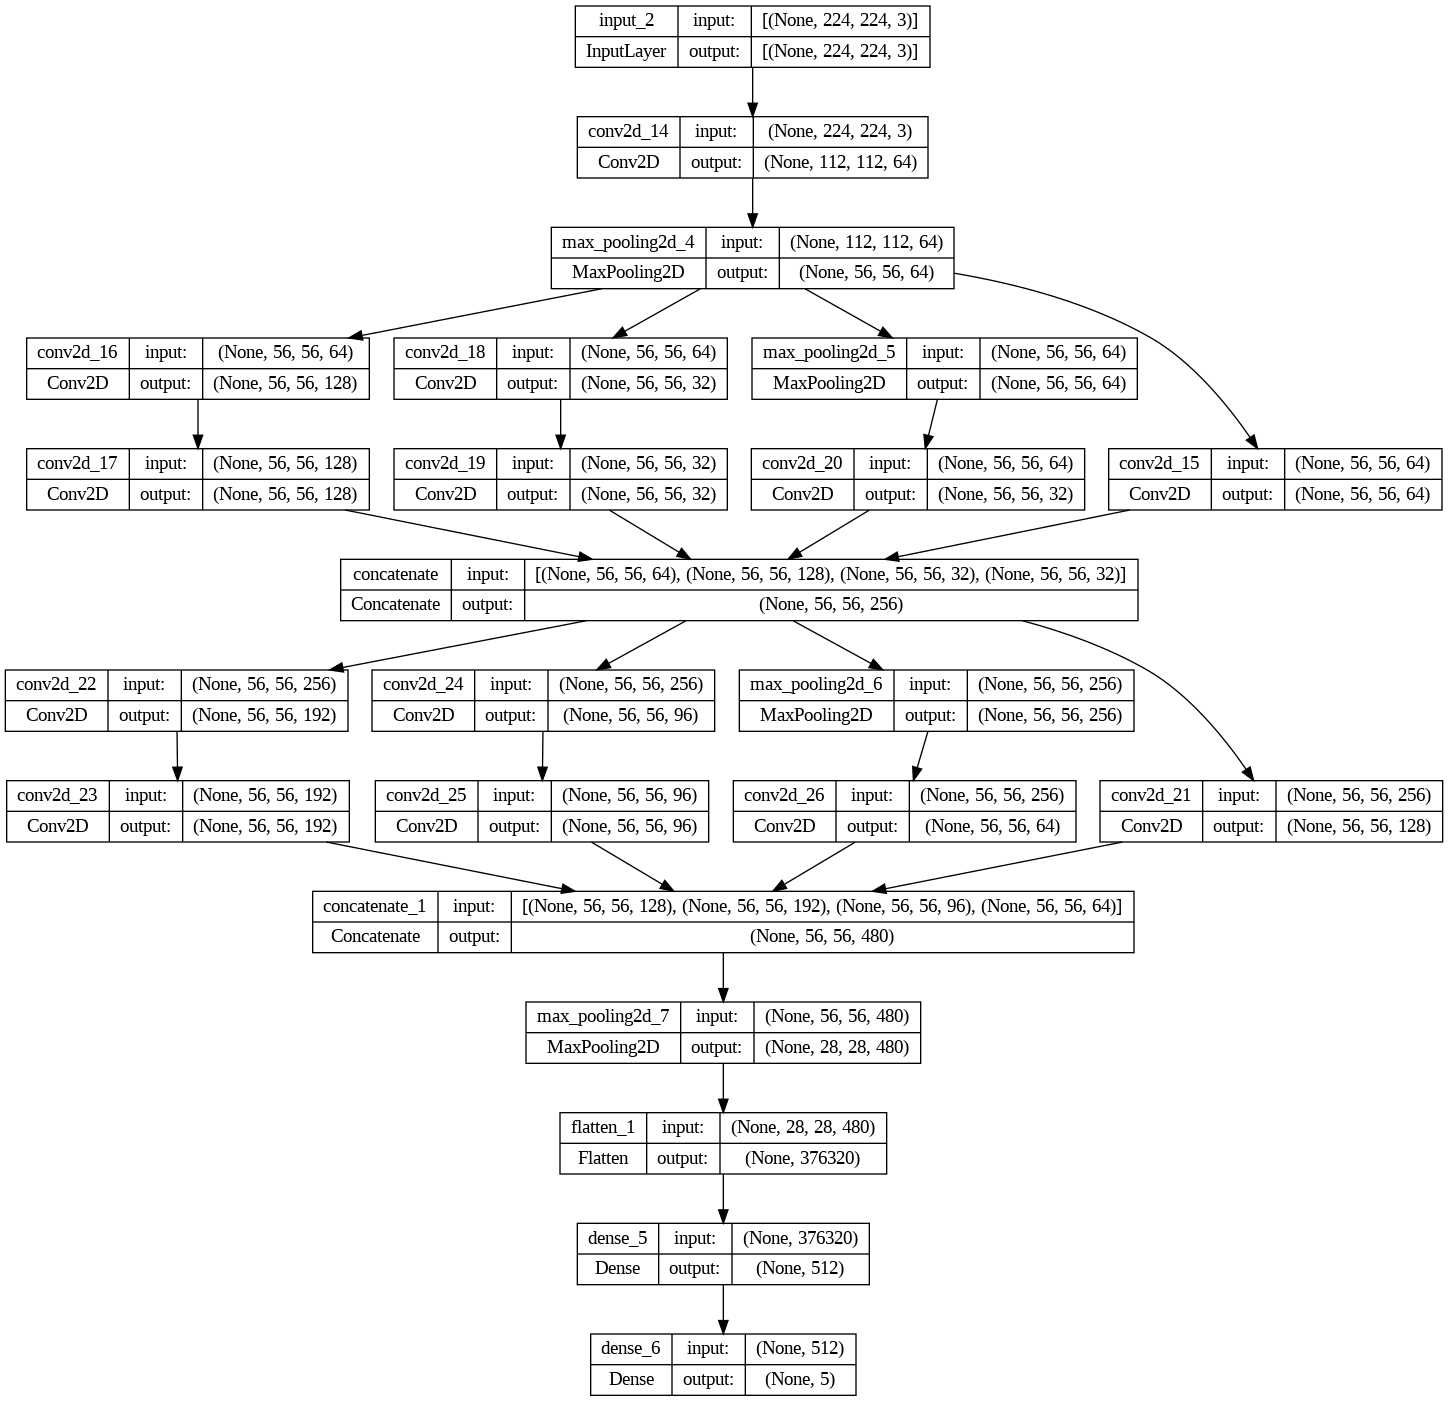

In [57]:
tf.keras.utils.plot_model(inception_model, show_shapes=True)

###Custom Model

In [58]:
save_dir = '/content/Model_Custom'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)

checkpoint_filepath = os.path.join(save_dir, "checkpoint-{epoch:02d}-{val_loss:.2f}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

# Define the Custom Block
def custom_block(x, filters, stride=1):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(5, 5), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut connection if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define the Custom Model
def build_custom(input_shape, num_classes, num_blocks_list, num_filters):
    input_layer = Input(shape=input_shape)

    x = Conv2D(num_filters, kernel_size=(7, 7), strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Building the residual blocks
    for num_blocks in num_blocks_list:
        x = custom_block(x, filters=num_filters, stride=2)
        for _ in range(num_blocks - 1):
            x = custom_block(x, filters=num_filters, stride=1)
        num_filters *= 2  # Double the number of filters for the next block

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=x)

    return model

# Define input shape, number of classes, list of residual block counts, and number of filters
input_shape = (224, 224, 3)  # Example for images with size 224x224 and 3 color channels
num_classes = 5
num_blocks_list = [2, 2, 2]  # List of residual block counts for each block
num_filters = 64  # Number of filters in the first convolutional layer

# Create the Custom ResNet model
custom_model = build_custom(input_shape, num_classes, num_blocks_list, num_filters)

# Display the model summary
custom_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 112, 112, 64)         256       ['conv2d_27[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 re_lu_7 (ReLU)              (None, 112, 112, 64)         0         ['batch_normalization_9[

In [60]:
custom_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
history_custom = custom_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
54/54 [==============================] - 35s 315ms/step - loss: 1.6424 - accuracy: 0.3743 - val_loss: 5570.4229 - val_accuracy: 0.2232
Epoch 2/100
54/54 [==============================] - 15s 275ms/step - loss: 1.3255 - accuracy: 0.4606 - val_loss: 33.8316 - val_accuracy: 0.2299
Epoch 3/100
54/54 [==============================] - 15s 284ms/step - loss: 1.2841 - accuracy: 0.4830 - val_loss: 3.1364 - val_accuracy: 0.2924
Epoch 4/100
54/54 [==============================] - 15s 278ms/step - loss: 1.2708 - accuracy: 0.4976 - val_loss: 2.6620 - val_accuracy: 0.2567
Epoch 5/100
54/54 [==============================] - 15s 278ms/step - loss: 1.2315 - accuracy: 0.5094 - val_loss: 1.7086 - val_accuracy: 0.3817
Epoch 6/100
54/54 [==============================] - 15s 277ms/step - loss: 1.2251 - accuracy: 0.5123 - val_loss: 1.7043 - val_accuracy: 0.4554
Epoch 7/100
54/54 [==============================] - 18s 331ms/step - loss: 1.1861 - accuracy: 0.5358 - val_loss: 3.6998 - val_accur

In [62]:
model_custom = tf.keras.models.load_model("/content/Model_Custom/checkpoint-90-1.18.h5")

In [63]:
scores_custom = custom_model.evaluate(test_ds)
#test_loss, test_accuracy = custom_model.evaluate(test_ds)

8/8 [==============================] - 3s 375ms/step - loss: 3.2078 - accuracy: 0.4960


8/8 [==============================] - 1s 50ms/step


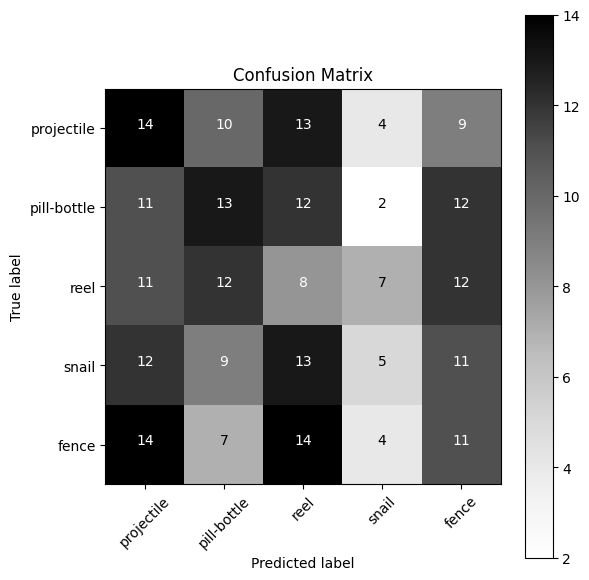

In [64]:
predictions_custom = model_custom.predict(test_ds)
predicted_label_custom = np.argmax(predictions_custom, axis=1)
true_label_custom = np.concatenate([y for x, y in test_ds], axis=0)
confusion_mtx_custom = confusion_matrix(true_label_custom, predicted_label_custom)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define your class names (if available)
class_names = ['projectile', 'pill-bottle', 'reel', 'snail', 'fence']

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx_custom, class_names)
plt.show()

In [65]:
from sklearn.metrics import classification_report

# Assuming you have loaded your model and made predictions as in the previous code

# Generate a classification report
report = classification_report(true_label_custom, predicted_label_custom, target_names=['projectile', 'pill-bottle', 'reel', 'snail', 'fence'])

# Print or display the classification report
print(report)

              precision    recall  f1-score   support

  projectile       0.23      0.28      0.25        50
 pill-bottle       0.25      0.26      0.26        50
        reel       0.13      0.16      0.15        50
       snail       0.23      0.10      0.14        50
       fence       0.20      0.22      0.21        50

    accuracy                           0.20       250
   macro avg       0.21      0.20      0.20       250
weighted avg       0.21      0.20      0.20       250



In [66]:
# Initialize variables to store aggregate metrics
sensitivity_sum = 0
specificity_sum = 0
ppv_sum = 0
npv_sum = 0

# Iterate over each class
for class_label in range(confusion_mtx_custom.shape[0]):
    tp = confusion_mtx_custom[class_label, class_label]
    fn = np.sum(confusion_mtx_custom[class_label, :]) - tp
    fp = np.sum(confusion_mtx_custom[:, class_label]) - tp
    tn = np.sum(confusion_mtx_custom) - (tp + fn + fp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    sensitivity_sum += sensitivity
    specificity_sum += specificity
    ppv_sum += ppv
    npv_sum += npv

# Calculate average metrics across all classes
num_classes = confusion_mtx_custom.shape[0]
sensitivity_avg = sensitivity_sum / num_classes
specificity_avg = specificity_sum / num_classes
ppv_avg = ppv_sum / num_classes
npv_avg = npv_sum / num_classes

# Print or display the aggregate metrics
print("Sensitivity (Average):", sensitivity_avg)
print("Specificity (Average):", specificity_avg)
print("PPV (Positive Predictive Value) (Average):", ppv_avg)
print("NPV (Negative Predictive Value) (Average):", npv_avg)

Sensitivity (Average): 0.20400000000000001
Specificity (Average): 0.8009999999999999
PPV (Positive Predictive Value) (Average): 0.2082628946006555
NPV (Negative Predictive Value) (Average): 0.8008319874850175


In [67]:
show['Custom_model'] = scores_custom[1]

In [68]:
history_custom.history.keys()
history_custom.history

{'loss': [1.6423912048339844,
  1.3254714012145996,
  1.2841006517410278,
  1.270769715309143,
  1.2315260171890259,
  1.2250725030899048,
  1.1861261129379272,
  1.2006003856658936,
  1.1596349477767944,
  1.1729049682617188,
  1.1548618078231812,
  1.1286240816116333,
  1.1118990182876587,
  1.0985249280929565,
  1.0970094203948975,
  1.0820914506912231,
  1.0820151567459106,
  1.0785744190216064,
  1.0480002164840698,
  1.0529632568359375,
  1.027829885482788,
  1.0231167078018188,
  1.0121570825576782,
  0.9909118413925171,
  0.9832085371017456,
  0.9714608788490295,
  0.9590119123458862,
  0.9615363478660583,
  0.9638330340385437,
  0.9497339725494385,
  0.9431397914886475,
  0.927332878112793,
  0.8937360048294067,
  0.9319235682487488,
  0.876964271068573,
  0.8684868812561035,
  0.8556398153305054,
  0.8542661666870117,
  0.8477286100387573,
  0.8248817920684814,
  0.8188825249671936,
  0.8010574579238892,
  0.8089824318885803,
  0.7822260856628418,
  0.7866247296333313,
  0.76

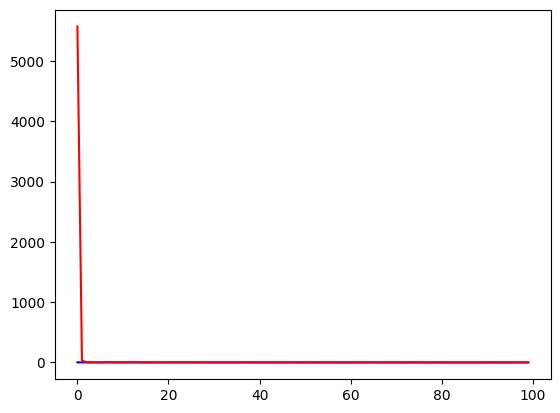

In [69]:
plt.plot(range(100), history_custom.history["loss"][:100], 'b')
plt.plot(range(100), history_custom.history["val_loss"][:100], 'r')
plt.show()

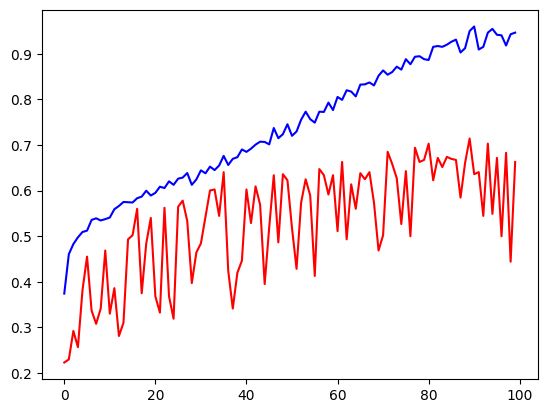

In [70]:
plt.plot(range(100), history_custom.history["accuracy"][:100], 'b')
plt.plot(range(100), history_custom.history["val_accuracy"][:100], 'r')
plt.show()

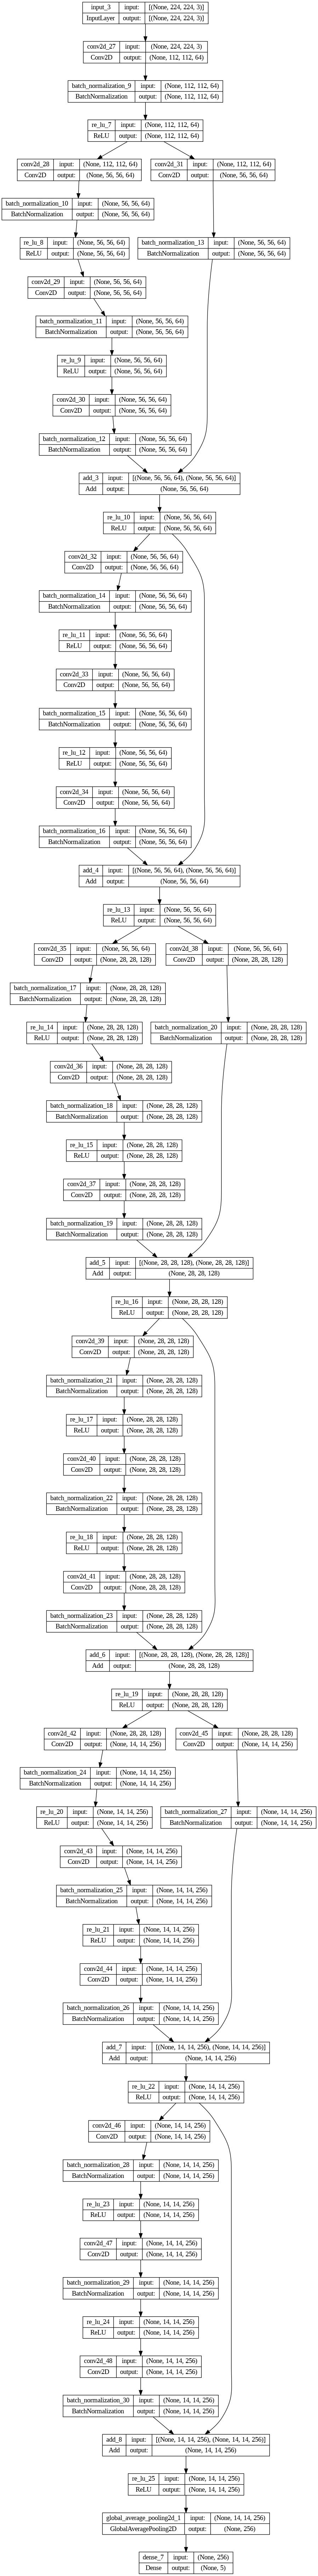

In [71]:
tf.keras.utils.plot_model(custom_model, show_shapes=True)

###Predicting images by previously build **AlexNet**

In [72]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


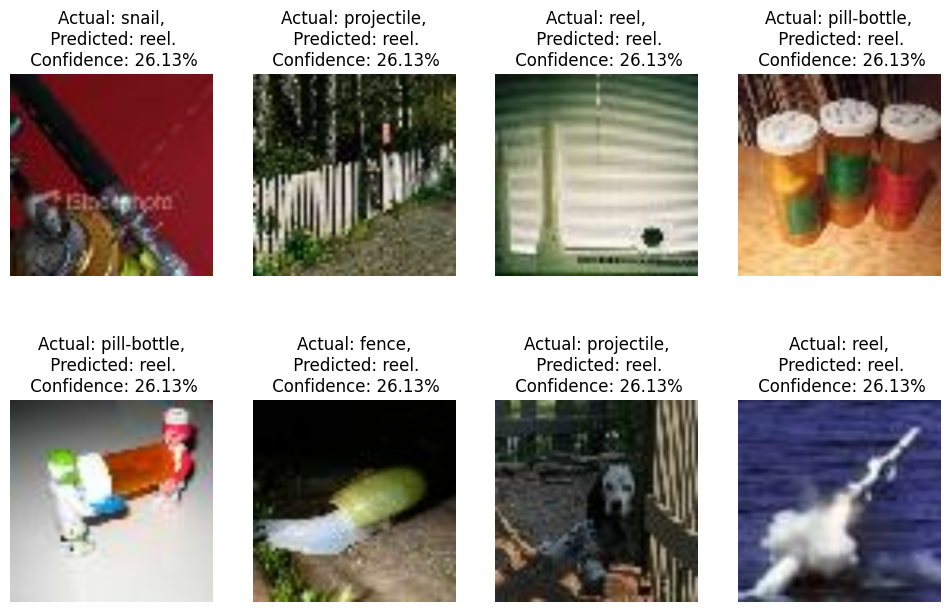

In [73]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_alex, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

###Predicting images by previously build **ResNet50**

1/1 [==============================] - 0s 19ms/step


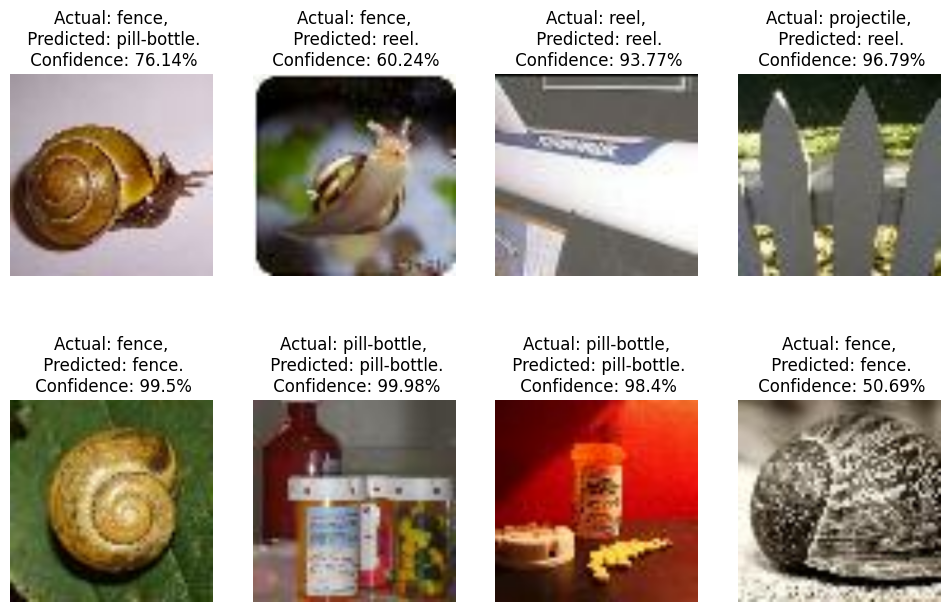

In [74]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_resnet, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

###Predicting images by previously build **InceptionNet**

1/1 [==============================] - 0s 19ms/step


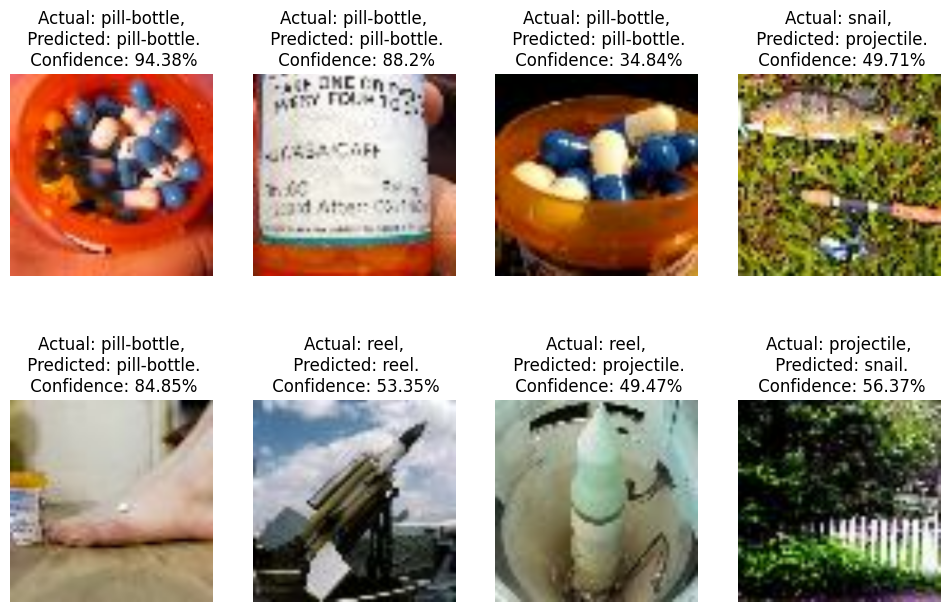

In [75]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_inception, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

###Predicting images by previously build **Custom Model**

1/1 [==============================] - 0s 20ms/step


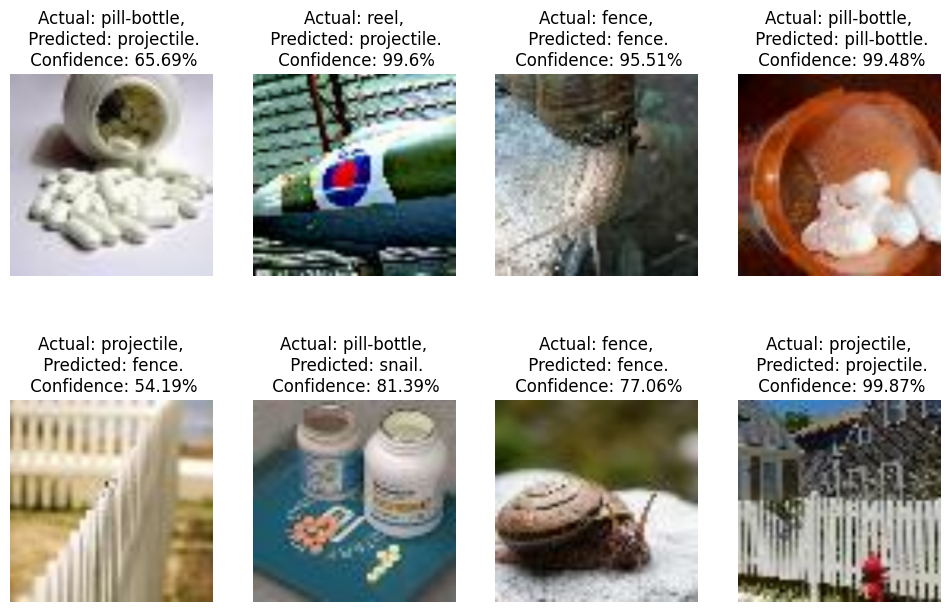

In [76]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_custom, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

###Comparison Graphs

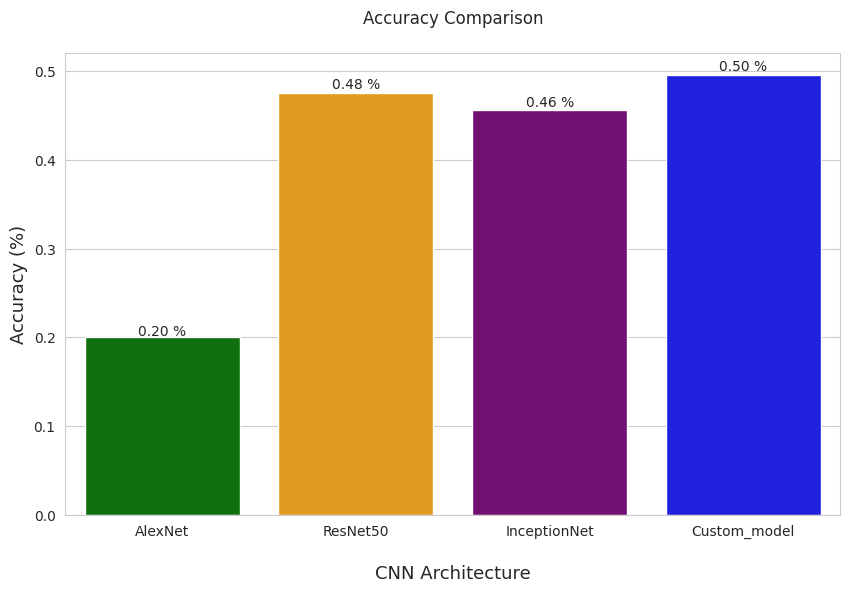

In [77]:
import seaborn as sns
colors = ["green","orange","purple","blue"]
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(x=list(show.keys()), y=list(show.values()),palette=colors)
plt.xlabel("\nCNN Architecture", fontsize=13)
plt.ylabel("Accuracy (%)", fontsize=13)
plt.title("Accuracy Comparison\n")
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x = p.get_x()
    y = p.get_y()
    ax.annotate(f"{height:.2f} %", (x + width/2, y+ height*1.01), ha="center")
plt.show()